# Word Embedding
- 단어들을 의미있는 실수로 구성된 밀집 벡터(Dense vector)의 형태로 표현하는 방법



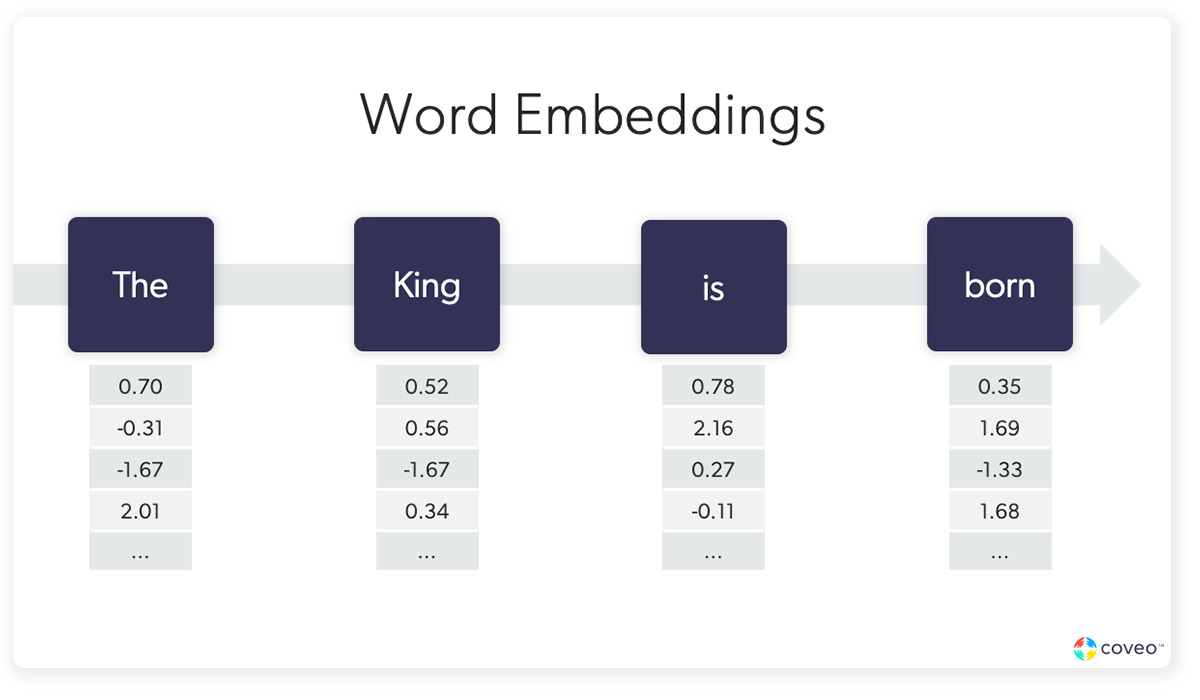

## One-Hot vector vs Embedding vector
- One-Hot vector
    - 고차원
    - 희소 표현
    - 값이 0 또는 1
- Embedding vector
    - 저차원
    - 밀집 표현
    - 값이 실수
    - 학습을 통해 얻을 수 있음



# Word2Vec
- 단어 임베딩을 하는 방법으로 단어 임베딩을 목적으로 구현된 신경망 모형
- 신경망 모델을 사용하여 방대한 텍스트에서 단어 연관을 학습
- CBOW 또는 Skip-gram 방식으로 학습하여 단어의 임베딩을 만든다.
- CBOW
    - 앞과 뒤에 있는 단어들을 이용해서 가운데 있는 단어를 예측하는 방식으로 학습

- Skip-gram
    - 가운데 단어를 이용해서 주변 단어를 예측하는 방식으로 학습


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

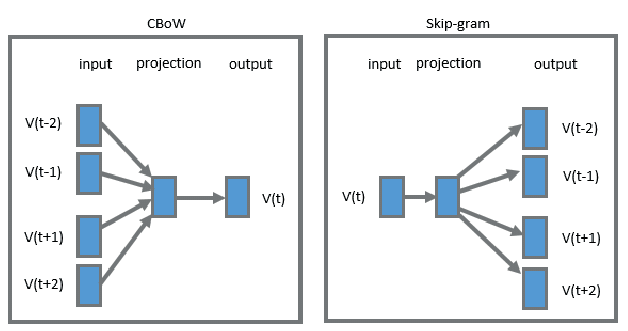

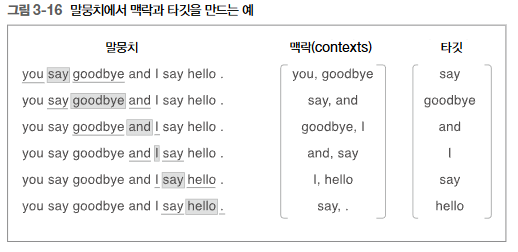

In [1]:
import sys
sys.path.append('..')
from common.util import preprocess

text='You say goodbye and I say hello'
corpus, word_to_id,id_to_word=preprocess(text)
print(corpus)
print(id_to_word)


[0 1 2 3 4 1 5]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello'}


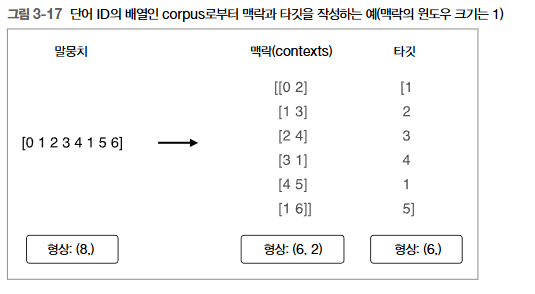

In [5]:
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            print(idx,t)
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

create_contexts_target(corpus,window_size=1)

1 -1
1 1
2 -1
2 1
3 -1
3 1
4 -1
4 1
5 -1
5 1


(array([[0, 2],
        [1, 3],
        [2, 4],
        [3, 1],
        [4, 5]]),
 array([1, 2, 3, 4, 1]))

In [9]:
from common.util import preprocess,create_contexts_target,convert_one_hot

text='You say goodbye and I say hello'
corpus, word_to_id,id_to_word=preprocess(text)

contexts,target=create_contexts_target(corpus,window_size=1)

vocab_size=len(word_to_id)
target=create_contexts_target(corpus,window_size=1)
contexts=convert_one_hot(contexts,vocab_size)

vocab_size,target,contexts

(6,
 (array([[0, 2],
         [1, 3],
         [2, 4],
         [3, 1],
         [4, 5]]),
  array([1, 2, 3, 4, 1])),
 array([[[1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 0]],
 
        [[0, 0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1]]]))

In [52]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        np.random.seed(42)  # 시드 고정
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        self._init_W_in = 0.01 * np.random.randn(V, H).astype('f')  # 초기 가중치 저장
        self.W_in = self._init_W_in.copy()  # W_in은 갱신될 가중치
        self.W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(self.W_in)
        self.in_layer1 = MatMul(self.W_in)
        self.out_layer = MatMul(self.W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = self.W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

    def update(self, learning_rate=0.1):
        for param, grad in zip(self.params, self.grads):
            param -= learning_rate * grad  # 파라미터 갱신

    def compare_weights(self):
        # 초기 가중치와 학습 후 가중치를 비교
        print("Initial W_in:")
        print(self._init_W_in)
        print("\nUpdated W_in (after training):")
        print(self.W_in)


In [47]:
np.random.seed(42)
0.01 * np.random.randn(len(word_to_id), 5).astype('f')

array([[ 0.00496714, -0.00138264,  0.00647689,  0.0152303 , -0.00234153],
       [-0.00234137,  0.01579213,  0.00767435, -0.00469474,  0.0054256 ],
       [-0.00463418, -0.0046573 ,  0.00241962, -0.0191328 , -0.01724918],
       [-0.00562287, -0.01012831,  0.00314247, -0.00908024, -0.01412304],
       [ 0.01465649, -0.00225776,  0.00067528, -0.01424748, -0.00544383],
       [ 0.00110923, -0.01150994,  0.00375698, -0.00600639, -0.00291694],
       [-0.00601707,  0.01852278, -0.00013497, -0.01057711,  0.00822545]],
      dtype=float32)

In [48]:
# coding: utf-8
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)


| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

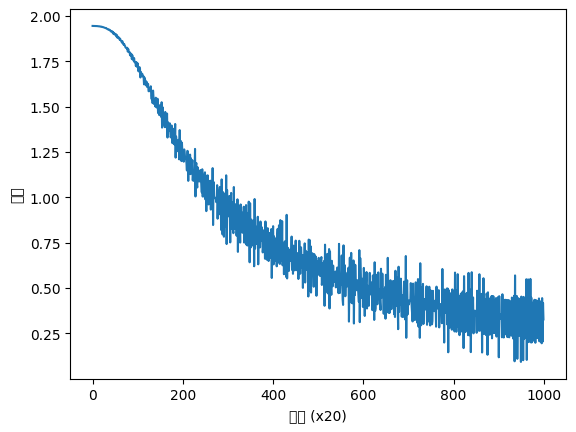

you [ 0.9830866  -0.97823924  1.7119857  -0.95446414 -0.9805455 ]
say [-1.1440487   1.1586481   1.2052033   0.03211051  1.1432638 ]
goodbye [ 0.9612531 -1.0075774 -0.7356819 -0.9721973 -1.0284076]
and [-0.8774366   0.76084733  1.2221006   1.8881196   0.8316108 ]
i [ 0.97011834 -0.9932891  -0.7450985  -0.959175   -1.0035784 ]
hello [ 0.98288345 -0.99187165  1.7130843  -0.9787286  -0.98401904]
. [-1.1052811   1.1643442   0.66828305 -1.6662426   1.1175241 ]


In [49]:
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

In [51]:
model.compare_weights()

Initial W_in:
[[ 0.00496714 -0.00138264  0.00647689  0.0152303  -0.00234153]
 [-0.00234137  0.01579213  0.00767435 -0.00469474  0.0054256 ]
 [-0.00463418 -0.0046573   0.00241962 -0.0191328  -0.01724918]
 [-0.00562287 -0.01012831  0.00314247 -0.00908024 -0.01412304]
 [ 0.01465649 -0.00225776  0.00067528 -0.01424748 -0.00544383]
 [ 0.00110923 -0.01150994  0.00375698 -0.00600639 -0.00291694]
 [-0.00601707  0.01852278 -0.00013497 -0.01057711  0.00822545]]

Updated W_in (after training):
[[ 0.9830866  -0.97823924  1.7119857  -0.95446414 -0.9805455 ]
 [-1.1440487   1.1586481   1.2052033   0.03211051  1.1432638 ]
 [ 0.9612531  -1.0075774  -0.7356819  -0.9721973  -1.0284076 ]
 [-0.8774366   0.76084733  1.2221006   1.8881196   0.8316108 ]
 [ 0.97011834 -0.9932891  -0.7450985  -0.959175   -1.0035784 ]
 [ 0.98288345 -0.99187165  1.7130843  -0.9787286  -0.98401904]
 [-1.1052811   1.1643442   0.66828305 -1.6662426   1.1175241 ]]


In [ ]:
DATA_PATH = os.getcwd()
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device,DATA_PATH

In [3]:
df = pd.read_csv(f"{DATA_PATH}/data/imdb/imdb_dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


- 정답 데이터

In [4]:
target = (df["sentiment"] == "positive").astype(int).to_numpy().reshape(-1,1)
target

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

# 토큰화 하기

In [5]:
import re # 파이썬의 정규표현식 내장 모듈
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # 불용어 목록

In [6]:
re_pat = re.compile(r"\b\w{2,}\b") # \w: 알파벳 + 숫자 + _ 중의 한 문자

def tokenizer(text, re_pat, stop_words):
    words = []
    text = text.lower() # 소문자화
    for w in re_pat.findall(text): # 정규표현식에 매칭되는 단어 리스트에 담아서 반환
        if w not in stop_words: # 불용어 제거
            words.append(w) # 단어 토큰 append
    return words

In [7]:
docs = [] # docs는  2차원 형태의 자료형
for text in df["review"]:
    doc = tokenizer(text, re_pat, ENGLISH_STOP_WORDS)
    docs.append(doc)

docs,len(docs)

([['reviewers',
   'mentioned',
   'watching',
   'just',
   'oz',
   'episode',
   'll',
   'hooked',
   'right',
   'exactly',
   'happened',
   'br',
   'br',
   'thing',
   'struck',
   'oz',
   'brutality',
   'unflinching',
   'scenes',
   'violence',
   'set',
   'right',
   'word',
   'trust',
   'faint',
   'hearted',
   'timid',
   'pulls',
   'punches',
   'regards',
   'drugs',
   'sex',
   'violence',
   'hardcore',
   'classic',
   'use',
   'word',
   'br',
   'br',
   'called',
   'oz',
   'nickname',
   'given',
   'oswald',
   'maximum',
   'security',
   'state',
   'penitentary',
   'focuses',
   'mainly',
   'emerald',
   'city',
   'experimental',
   'section',
   'prison',
   'cells',
   'glass',
   'fronts',
   'face',
   'inwards',
   'privacy',
   'high',
   'agenda',
   'em',
   'city',
   'home',
   'aryans',
   'muslims',
   'gangstas',
   'latinos',
   'christians',
   'italians',
   'irish',
   'scuffles',
   'death',
   'stares',
   'dodgy',
   'dealings

In [8]:
len(docs[0]),len(docs[1])

(156, 83)

# Word2Vec
- 주요 파라미터
    - 첫번째 인수로 토큰화된 데이터셋을 전달
    - vector_size: 단어의 임베딩 차원크기
    - sg: 0 이면 CBOW, 1 이면 skip-gram
    - seed: 시드값
    - window: 윈도우사이즈
    - min_count: 최소 단어 빈도수
    - epochs:  에폭수

In [9]:
from gensim.models.word2vec import Word2Vec
emb_model_sg = Word2Vec(docs, vector_size=64, sg=1, seed=SEED, min_count=1)
emb_model_cb = Word2Vec(docs, vector_size=64, sg=0, seed=SEED, min_count=1)

# 내부적으로 임베딩을 학습하고 있음 시간이 조금 걸림

- 모델 저장하기

In [10]:
emb_model_sg.save(r"C:\PapersWithCode\04_NLP\data\word2vec_sg")
emb_model_cb.save(r"C:\PapersWithCode\04_NLP\data\word2vec_cb")

- 저장된 모델 불러오기

In [11]:
emb_model_sg = Word2Vec.load(r"C:\PapersWithCode\04_NLP\data\word2vec_sg")
emb_model_cb = Word2Vec.load(r"C:\PapersWithCode\04_NLP\data\word2vec_cb")

- 단어별 인덱스 번호 확인하기

In [12]:
emb_model_sg.wv.key_to_index

{'br': 0,
 'movie': 1,
 'film': 2,
 'like': 3,
 'just': 4,
 'good': 5,
 'time': 6,
 'story': 7,
 'really': 8,
 'bad': 9,
 'people': 10,
 'great': 11,
 'don': 12,
 'make': 13,
 'way': 14,
 'movies': 15,
 'characters': 16,
 'think': 17,
 'watch': 18,
 'character': 19,
 'films': 20,
 'seen': 21,
 'love': 22,
 'plot': 23,
 'life': 24,
 'acting': 25,
 'did': 26,
 'best': 27,
 'know': 28,
 'little': 29,
 'man': 30,
 'does': 31,
 'better': 32,
 'end': 33,
 'scene': 34,
 'say': 35,
 'scenes': 36,
 've': 37,
 'real': 38,
 'thing': 39,
 'watching': 40,
 'actors': 41,
 'doesn': 42,
 'director': 43,
 'didn': 44,
 'years': 45,
 'funny': 46,
 'old': 47,
 '10': 48,
 'work': 49,
 'actually': 50,
 'makes': 51,
 'look': 52,
 'going': 53,
 'new': 54,
 'lot': 55,
 'world': 56,
 'cast': 57,
 'things': 58,
 'want': 59,
 'quite': 60,
 'pretty': 61,
 'horror': 62,
 'young': 63,
 'big': 64,
 'got': 65,
 'thought': 66,
 'fact': 67,
 'long': 68,
 'comedy': 69,
 'series': 70,
 'right': 71,
 'action': 72,
 'music'

In [13]:
len(emb_model_sg.wv.key_to_index),len(emb_model_cb.wv.key_to_index) # 학습된 총 단어 개수 확인

(101583, 101583)

In [14]:
emb_model_sg.wv.vectors.shape,emb_model_cb.wv.vectors.shape

((101583, 64), (101583, 64))

- 0번단어의 임베딩 벡터를 보고싶다면?

In [15]:
emb_model_sg.wv[0]-emb_model_cb.wv[0]

array([ 0.6296215 ,  0.1987809 , -0.8037553 ,  0.546856  , -0.38530496,
       -0.2696128 ,  1.6922542 ,  0.23981275,  1.2263443 , -0.37446994,
       -0.01889198, -0.5415348 ,  1.0241263 , -1.4723608 ,  0.13209045,
       -0.27790576, -0.89032096,  0.7841184 , -0.48366475, -0.9656424 ,
       -0.65704805, -0.7245347 , -0.14731981, -1.0989118 ,  0.79257184,
        1.1830672 ,  0.18451084,  0.9162165 ,  0.04033877, -1.139078  ,
       -1.0969919 ,  1.3699585 ,  1.7656928 ,  0.7985712 , -0.31680635,
        1.6773322 ,  1.0552408 ,  0.5337688 , -0.35815114, -1.220102  ,
        0.12924956, -0.2788623 , -1.8723207 ,  0.8337064 ,  0.05774297,
       -0.5408558 , -1.9576937 ,  0.41650853, -1.833528  , -0.8166412 ,
       -0.730553  ,  1.3658484 , -0.7704187 ,  0.0723844 , -0.21129027,
        0.00252253, -2.0176933 ,  1.3074063 ,  0.17866188, -1.5707194 ,
       -0.526927  , -0.5939987 ,  0.50384974, -0.3044769 ], dtype=float32)

In [16]:
emb_model_sg.wv[0],emb_model_cb.wv[0]

(array([ 0.11756487, -0.36668992,  0.28357568, -0.01544739, -0.5153339 ,
         0.22926489, -0.16327693,  0.01955589, -0.4824118 ,  0.17828013,
        -0.20111312,  0.12724204,  0.0748114 , -0.32941094, -0.19696093,
         0.2349652 , -0.04687328,  0.4191739 , -0.1297975 ,  0.2750538 ,
         0.00457248, -0.26624957, -0.34907752, -0.05275805,  0.635461  ,
         0.06703214, -0.21479766, -0.106451  , -0.13174322,  0.28005636,
        -0.19275619, -0.08816476, -0.5574814 , -0.00501592, -0.03986977,
        -0.58479214,  0.22963163,  0.10023604,  0.09611702,  0.20953892,
        -0.1736701 , -0.0577475 ,  0.03077132, -0.00327098,  0.1265844 ,
         0.76777464, -0.19236253,  0.087241  ,  0.10819501, -0.04902406,
         0.42456716,  0.20181593, -0.02932758, -0.23067169, -0.5435294 ,
        -0.32557997,  0.07072203, -0.02764235,  0.10119222, -0.35330966,
         0.19234893, -0.22816992, -0.18021068,  0.4200715 ], dtype=float32),
 array([-0.51205665, -0.5654708 ,  1.0873309 , 

In [17]:
emb_model_sg.wv["hello"] # 단어를 넣어도 된다.

array([ 0.05479654,  0.02393303,  0.47936404, -0.1484682 , -0.8412211 ,
       -0.13148057, -0.01884993,  0.16089438,  0.01172946, -0.00673211,
       -0.4198062 ,  0.38526493, -0.169085  , -0.27140787, -0.26056394,
        0.30122778, -0.73213613,  0.11526673, -0.5540675 ,  0.6636367 ,
        0.15594544, -0.24497193, -0.5536696 , -0.16217397,  0.44985357,
       -0.41244426, -0.179635  , -0.14422904,  0.19745067,  0.4832136 ,
       -0.4964098 , -0.11540343, -0.5735103 , -0.40011486,  0.28572935,
       -0.12109637,  0.3905242 ,  0.32862303, -0.07819159,  0.2670434 ,
       -0.00336855,  0.50190467, -0.38619494, -0.46556598,  0.32329407,
        0.31350318,  0.25711828, -0.3543309 , -0.05603085, -0.55903184,
        0.2964212 ,  0.25759223, -0.12981829,  0.00894117, -0.7664017 ,
       -0.23697418,  0.23411271,  0.17217065,  0.36270776, -0.32728443,
       -0.4819665 , -0.04895326,  0.10252579,  0.3555868 ], dtype=float32)

In [18]:
emb_model_cb.wv["hello"]

array([ 1.7652212e-01,  6.7561555e-01,  9.8209774e-01, -4.1863382e-01,
       -3.4398717e-01, -1.5815090e-01, -3.0827710e-01,  3.3149436e-01,
       -3.8135976e-01,  3.9040935e-01, -3.5012832e-01,  6.3658684e-01,
       -9.3525112e-02, -2.3361102e-02, -2.5351152e-01, -3.1067544e-01,
       -7.4848282e-01,  1.7582457e-01, -3.6678791e-01,  7.7909178e-01,
        9.6455723e-02, -1.6327211e-01, -5.7314789e-01, -6.5603018e-01,
        5.4623860e-01, -9.9370438e-01,  7.6642025e-01, -1.3075979e-01,
        5.4270022e-02,  3.0523163e-01, -3.7122157e-01, -7.6425302e-01,
       -2.0281583e-01, -1.0793610e+00,  2.5873059e-01,  6.1607589e-03,
        4.2610466e-01,  3.2581469e-01,  6.1794097e-04,  6.6674548e-01,
        7.6360621e-02,  6.1727834e-01, -7.2526294e-01, -5.8834225e-01,
        1.2399665e+00,  3.2777724e-01,  5.2208614e-01, -6.2530738e-01,
        9.1100469e-02, -8.7012684e-01,  2.7571052e-01,  5.1643544e-01,
       -9.8537050e-02,  5.2068353e-01, -6.8782049e-01,  7.1164310e-02,
      

In [19]:
# emb_model.wv["lks"] # 학습이 안된 단어에 경우 에러 발생

- 두 단어의 유사도 보기

In [20]:
emb_model_sg.wv.similarity("hello","hi")

0.6138345

- 특정 단어와 유사도 높은 단어 Top-n 보기

In [21]:
emb_model_cb.wv.most_similar("hello", topn=10)

[('yep', 0.8281176686286926),
 ('slept', 0.7536507248878479),
 ('goodbye', 0.7530166506767273),
 ('gosh', 0.7461002469062805),
 ('dear', 0.7447790503501892),
 ('kissed', 0.7412432432174683),
 ('hmm', 0.7398139238357544),
 ('exclaim', 0.7312169075012207),
 ('ya', 0.7291283011436462),
 ('yea', 0.7256632447242737)]

# 2차원 형태의 학습 데이터 만들기
- 각 샘플에서 토큰화 리스트를  하나씩 꺼낸다.
- 토큰화 리스트에서 토큰을 하나씩 꺼내서 임베딩 벡터로 만든다.
- 임베딩 벡터들을 평균내서 1차원 벡터로 변환후 리스트에 담기

In [22]:
emb_model_sg.wv.key_to_index.get("hi"),emb_model_sg.wv["hi"]

(4589,
 array([ 0.09488509, -0.8708902 ,  0.33080393, -0.7412028 , -0.8110316 ,
         0.17487402, -0.00668234, -0.01107565, -0.21952334, -0.03367258,
         0.1421181 ,  0.1203059 , -0.202996  , -0.29149833, -0.19901603,
        -0.10117303, -0.22482368, -0.16877718, -0.67892265,  0.52316785,
        -0.04989894, -0.01209582, -0.52780455, -0.094378  ,  0.39194176,
        -0.45360935,  0.09798072, -0.38286376, -0.11587593,  0.22149092,
        -0.41912922,  0.16886759, -0.48670757, -0.67213297, -0.05216363,
        -0.65230596, -0.06580385, -0.18001081,  0.14298612,  0.30087945,
         0.18076831,  0.20027678,  0.00120775, -0.42173493, -0.099241  ,
         0.6227038 ,  0.19457987, -0.32239467, -0.6851736 , -0.13672161,
         0.03657116,  0.14159416,  0.12150732, -0.17929815, -0.26851782,
        -0.16059756, -0.02795564, -0.2375675 ,  0.56215954,  0.08391185,
        -0.08584398,  0.06786849,  0.02537599,  0.23377027], dtype=float32))

In [29]:
train_vec =  []
shape= []

for doc in tqdm(docs):
    # 학습이 안된 단어가 있을 수 있기 때문에 다음과 같이 조건식을 줘야 함.
    vec_sg = [ emb_model_sg.wv[w] for w in doc if emb_model_sg.wv.key_to_index.get(w) ]
    vec_cb = [ emb_model_cb.wv[w] for w in doc if emb_model_cb.wv.key_to_index.get(w) ]
    vec_sg = np.array(vec_sg)
    vec_cb = np.array(vec_cb)
    shape.append((vec_sg.shape,vec_cb.shape))
    vec_sg = vec_sg.mean(axis=0) # 문장 임베딩 벡터값을 압축 : 나는 밥을 먹는다 : 하나의 정보로 압축
    vec_cb = vec_cb.mean(axis=0) 
    train_vec.append(vec_sg+vec_cb)

train_vec = np.array(train_vec)
train_vec.shape

# seq의 형태는 아님

  0%|          | 0/50000 [00:00<?, ?it/s]

(50000, 64)

In [34]:
shape[:5]

[((150, 64), (150, 64)),
 ((77, 64), (77, 64)),
 ((74, 64), (74, 64)),
 ((62, 64), (62, 64)),
 ((109, 64), (109, 64))]

In [33]:
np.array(shape).shape

(50000, 2, 2)

# 머신러닝 모델에 CV 점수 확인해보기

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
cv = KFold(5, shuffle=True, random_state=SEED)

In [29]:
model = LogisticRegression(random_state=SEED)
scores = cross_val_score(model,train_vec,target,cv=cv, scoring="accuracy", n_jobs=-1)
scores.mean()

0.85856

# 데이터셋 클래스

In [30]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y # y의 shape가 (-1,1)이란 가정 하에

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        item = {}
        item["x"] = torch.Tensor(self.x[idx])
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])

        return item

# 모델클래스

In [33]:
class Net(torch.nn.Module):
    def __init__(self, n_features, drop_rate = 0.5):
        super().__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(n_features, 32),
            torch.nn.batchnorm1d(),
            torch.nn.ELU(),
            torch.nn.Dropout(drop_rate),

            torch.nn.Linear(32, 16),
            torch.nn.batchnorm1d(),
            torch.nn.ELU(),

            torch.nn.Linear(16, 8),
            torch.nn.ELU(),

            torch.nn.Linear(8, 1),
        )

    def forward(self, x):
        return self.seq(x)

# 학습 loop 함수

In [34]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    epoch_loss = 0
    model.train() # 학습 모드
    
    for batch in dataloader:
        pred = model( batch["x"].to(device) )
        loss = loss_fn( pred, batch["y"].to(device) )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    return epoch_loss

# 테스트 및 검증 loop 함수

In [35]:
@torch.no_grad()
def test_loop(dataloader, model, loss_fn, device):
    epoch_loss = 0
    pred_list = []
    act_func = torch.nn.Sigmoid()
    model.eval() # 평가 모드
    
    for batch in dataloader:
        pred = model( batch["x"].to(device) )

        if batch.get("y") is not None:
            loss = loss_fn( pred, batch["y"].to(device) )
            epoch_loss += loss.item()

        pred = act_func(pred) # logit 값을 확률로 변환
        pred = pred.to("cpu").numpy() # cpu 이동후 ndarray 로변환
        pred_list.append(pred)

    epoch_loss /= len(dataloader)
    pred = np.concatenate(pred_list)
    return epoch_loss, pred

# 하이퍼파라미터

In [36]:
batch_size = 32 # 배치 사이즈
loss_fn = torch.nn.BCEWithLogitsLoss() # 손실 객체
epochs = 100 # 최대 가능한 에폭수
n_features = train_vec.shape[1] # 피처 개수

# 학습

In [37]:
from sklearn.metrics import accuracy_score

In [41]:
is_holdout = False
reset_seeds(SEED) # 재현을 위해 시드고정
best_score_list = []

for i, (tri, vai) in enumerate( cv.split(train_vec) ):
    # 학습용 데이터로더 객체
    train_dt = ReviewDataset(train_vec[tri], target[tri])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용 데이터로더 객체
    valid_dt = ReviewDataset(train_vec[vai], target[vai])
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    # 모델 객체와 옵티마이저 객체 생성
    model = Net(n_features).to(device)
    optimizer = torch.optim.Adam( model.parameters() )

    best_score = 0 # 현재 최고 점수
    patience = 0 # 조기 종료 조건을 주기 위한 변수

    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
        valid_loss, pred = test_loop(valid_dl, model, loss_fn, device)

        pred = (pred > 0.5).astype(int)
        score = accuracy_score(target[vai], pred)

        #print(train_loss, valid_loss, score)
        if score > best_score:
            best_score = score # 최고 점수 업데이트
            patience = 0
            torch.save(model.state_dict(), f"{DATA_PATH}/data/imdb/weight/model_sg&sb{i}.pth") # 최고 점수 모델 가중치 저장

        patience += 1
        if patience == 5:
            break

    print(f"{i}번째 폴드 최고 ACC: {best_score}")
    best_score_list.append(best_score)
    if is_holdout:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

0번째 폴드 최고 ACC: 0.8607


  0%|          | 0/100 [00:00<?, ?it/s]

1번째 폴드 최고 ACC: 0.8617


  0%|          | 0/100 [00:00<?, ?it/s]

2번째 폴드 최고 ACC: 0.8619


  0%|          | 0/100 [00:00<?, ?it/s]

3번째 폴드 최고 ACC: 0.8598


  0%|          | 0/100 [00:00<?, ?it/s]

4번째 폴드 최고 ACC: 0.8551


In [42]:
np.mean(best_score_list)

0.8598399999999999

# FastText
- Word2vec 개선
    - 신조어 문제 완화(OOV, Out of Vocabulary)
- 단어 토큰화가 아닌 글자 단위를 이용한 준단어 토큰화 방식
- 준단어 토큰의 임베딩의 합이 단어의 임베딩 벡터가 된다.

In [43]:
from gensim.models.fasttext import FastText
emb_model = FastText(docs, seed=SEED, vector_size=64, sg=1, min_count=1 )

In [42]:
emb_model.wv["lks"]

array([-0.40726697, -0.03011231, -0.20125143,  0.03259624, -0.40882707,
        0.85679656,  0.41335335,  0.52891725, -0.13991188, -0.19004686,
        0.18597476,  0.42478442, -0.01041719,  0.5491553 ,  0.01731392,
       -0.03040717,  0.06597969,  0.43624583,  0.07217436,  0.37085772,
       -0.41207638,  0.21626043,  0.06793072,  0.21430792, -0.20609073,
       -0.33565164, -0.54139113,  0.08832168,  0.03967634,  0.16174628,
        0.07882562, -0.10259711, -0.19726533,  0.6081906 , -0.32844236,
        0.30206206,  0.39406443, -0.20171553, -0.4594427 ,  0.15445681,
       -0.40112698,  0.002627  ,  0.18821387, -0.31697127,  0.5580258 ,
       -0.15858947,  0.474435  ,  0.24595992, -0.4326011 , -0.14494397,
        0.40931904, -0.16214155,  0.10978866, -0.40950105,  0.24804837,
       -0.53181416, -0.21346569,  0.3885421 ,  0.18783528, -0.06345852,
       -0.6687226 , -0.25022832,  0.12209809, -0.17275095], dtype=float32)

In [45]:
train_vec = []

for doc in tqdm(docs):
    # 학습이 안된 단어가 있을 수 있기 때문에 다음과 같이 조건식을 줘야 함.
    vec = [ emb_model.wv[w] for w in doc if emb_model.wv.key_to_index.get(w) ]

    vec = np.array(vec)
 
    vec = vec.mean(axis=0) # 문장 임베딩 벡터

    train_vec.append(vec)

train_vec = np.array(train_vec)
train_vec.shape

  0%|          | 0/50000 [00:00<?, ?it/s]

(50000, 64)

In [46]:
model = LogisticRegression(random_state=SEED)
scores = cross_val_score(model,train_vec,target,cv=cv, scoring="accuracy", n_jobs=-1)
scores.mean()

0.86862